# Tree-informed optimal transport of single-cell and spatial transcriptomics
Here we generate fake data consisting of paired spatial and single-cell gene expression data. We use Cassiopeia to generate a phylogenetic tree of single-cells and place them in 2D space, and from that we generate single-cell and spot-based gene expression. We then apply various approaches to map the single-cell data to spots.

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import squidpy as sq
import scanpy as sc
import seaborn as sns

import importlib
import os

file_path = os.path.join(os.getcwd(), "../src/spotr/", "space_simulator.py")
spec = importlib.util.spec_from_file_location("space_simulator", file_path)
space_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(space_simulator)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "expression_simulator.py")
spec = importlib.util.spec_from_file_location("expression_simulator", file_path)
expression_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(expression_simulator)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "visium_simulator.py")
spec = importlib.util.spec_from_file_location("visium_simulator", file_path)
visium_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(visium_simulator)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "mappers.py")
spec = importlib.util.spec_from_file_location("mappers", file_path)
mappers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mappers)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "utils.py")
spec = importlib.util.spec_from_file_location("utils", file_path)
utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

file_path = os.path.join(os.getcwd(), "../benchmark/DestVI/", "destvi.py")
spec = importlib.util.spec_from_file_location("destvi", file_path)
destvi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(destvi)

file_path = os.path.join(os.getcwd(), "../benchmark/scDOT/", "scdot.py")
spec = importlib.util.spec_from_file_location("scdot", file_path)
scdot = importlib.util.module_from_spec(spec)
spec.loader.exec_module(scdot)

In [ ]:
def run_methods(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix, true_couplings,
                methods=['Wasserstein OT', 'GW OT', 'SpOTr', 'scDOT', 'DestVI'],
                spatial_mode=None, expression_mode=None, rep=None):
    results_rows = []

    # ss_simulated_adata.layers['counts'] = ss_simulated_adata.X.copy()
    # spatial_simulated_adata.layers['counts'] = spatial_simulated_adata.X.copy()
    C_feature, C_tree, C_space, a, b = spotr.prepare_ot_inputs(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix.values, spatial_distance_matrix.values)
    true_structure_score_level0 = utils.structural_concordance(C_tree, C_space, true_couplings)
    level1_scores = []
    for clade in ss_simulated_adata.obs['clade_level1'].unique():
        clade_idx = np.where(ss_simulated_adata.obs['clade_level1'] == clade)[0]
        true_structure_score_level1 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, true_couplings[clade_idx], eps=1e-12)
        level1_scores.append(true_structure_score_level1)
    level2_scores = []
    for clade in ss_simulated_adata.obs['clade_level2'].unique():
        clade_idx = np.where(ss_simulated_adata.obs['clade_level2'] == clade)[0]
        true_structure_score_level2 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, true_couplings[clade_idx], eps=1e-12)
        level2_scores.append(true_structure_score_level2)

    if 'Wasserstein OT' in methods:
        print("Wasserstein OT")
        # Run Wasserstein OT
        coupling, _ = spotr.sinkhorn_fgw(C_feature, C_tree, C_space, a, b, 0.01, T_sinkhorn=100, J_alt=1, 
                                    alpha=0.0, gamma0=None, uv0=None)
        utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
        mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
        structure_score_level0 = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)
        level0_rmse = utils.compute_rmse(structure_score_level0, true_structure_score_level0)
        level1_rmse = []
        for i, clade in enumerate(ss_simulated_adata.obs['clade_level1'].unique()):
            clade_idx = np.where(ss_simulated_adata.obs['clade_level1'] == clade)[0]
            structure_score_level1 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
            level1_rmse.append(utils.compute_rmse(structure_score_level1, level1_scores[i]))
        level1_rmse = np.mean(level1_rmse)
        level2_rmse = []
        for i, clade in enumerate(ss_simulated_adata.obs['clade_level2'].unique()):
            clade_idx = np.where(ss_simulated_adata.obs['clade_level2'] == clade)[0]
            structure_score_level2 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
            level2_rmse.append(utils.compute_rmse(structure_score_level2, level2_scores[i]))
        level2_rmse = np.mean(level2_rmse)

        results_rows.append({
            'spatial_mode': spatial_mode,
            'expression_mode': expression_mode,
            'rep': rep,
            'method': 'Wasserstein OT',
            'pcorr': mean_pearson_corr,
            'structure_rmse_level0': level0_rmse,
            'structure_rmse_level1': level1_rmse,
            'structure_rmse_level2': level2_rmse
        })

    if 'GW OT' in methods:
        print("GW OT")
        # Run GW OT
        coupling, _ = spotr.sinkhorn_fgw(C_feature, C_tree, C_space, a, b, .01, T_sinkhorn=100, J_alt=20, alpha=1.0, gamma0=coupling, uv0=None) # start from WT 
        utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
        mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
        structure_score_level0 = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)
        level0_rmse = utils.compute_rmse(structure_score_level0, true_structure_score_level0)
        level1_rmse = []
        for i, clade in enumerate(ss_simulated_adata.obs['clade_level1'].unique()):
            clade_idx = np.where(ss_simulated_adata.obs['clade_level1'] == clade)[0]
            structure_score_level1 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
            level1_rmse.append(utils.compute_rmse(structure_score_level1, level1_scores[i]))
        level1_rmse = np.mean(level1_rmse)
        level2_rmse = []
        for i, clade in enumerate(ss_simulated_adata.obs['clade_level2'].unique()):
            clade_idx = np.where(ss_simulated_adata.obs['clade_level2'] == clade)[0]
            structure_score_level2 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
            level2_rmse.append(utils.compute_rmse(structure_score_level2, level2_scores[i]))
        level2_rmse = np.mean(level2_rmse)

        results_rows.append({
            'spatial_mode': spatial_mode,
            'expression_mode': expression_mode,
            'rep': rep,            
            'method': 'GW OT',
            'pcorr': mean_pearson_corr,
            'structure_rmse_level0': level0_rmse,
            'structure_rmse_level1': level1_rmse,
            'structure_rmse_level2': level2_rmse
        })

    if 'SpOTr' in methods:
        print("SpOTr")
        # Run SpOTr
        cell_type_assignments = ss_simulated_adata.obsm['trait_activations'].values / np.sum(ss_simulated_adata.obsm['trait_activations'].values, axis=1, keepdims=True)
        cell_type_signatures = ss_simulated_adata.uns['trait_signatures'].values # should probably learn this...
        res = spotr.run_spotr(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix,
                                                                    cell_type_assignments, cell_type_signatures,
                                                                    clade_column='clade_level1')
        coupling = res['coupling']
        utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
        mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
        structure_score_level0 = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)
        level0_rmse = utils.compute_rmse(structure_score_level0, true_structure_score_level0)
        level1_rmse = []
        for i, clade in enumerate(ss_simulated_adata.obs['clade_level1'].unique()):
            clade_idx = np.where(ss_simulated_adata.obs['clade_level1'] == clade)[0]
            structure_score_level1 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
            level1_rmse.append(utils.compute_rmse(structure_score_level1, level1_scores[i]))
        level1_rmse = np.mean(level1_rmse)
        level2_rmse = []
        for i, clade in enumerate(ss_simulated_adata.obs['clade_level2'].unique()):
            clade_idx = np.where(ss_simulated_adata.obs['clade_level2'] == clade)[0]
            structure_score_level2 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
            level2_rmse.append(utils.compute_rmse(structure_score_level2, level2_scores[i]))
        level2_rmse = np.mean(level2_rmse)

        results_rows.append({
            'spatial_mode': spatial_mode,
            'expression_mode': expression_mode,
            'rep': rep,            
            'method': 'SpOTr',
            'pcorr': mean_pearson_corr,
            'structure_rmse_level0': level0_rmse,
            'structure_rmse_level1': level1_rmse,
            'structure_rmse_level2': level2_rmse
        })

    if 'scDOT' in methods:
        print("scDOT")
        # scDOT
        spatial_simulated_adata.uns["markers"] = ss_simulated_adata.uns['trait_signatures'].values
        ss_simulated_adata.obsm["cell_type"] = ss_simulated_adata.obsm['trait_activations'].values / np.sum(ss_simulated_adata.obsm['trait_activations'].values, axis=1, keepdims=True)
        _, coupling = scdot.train_scdot(ss_simulated_adata, spatial_simulated_adata)
        coupling = coupling.T
        utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
        mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
        structure_score_level0 = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)
        level0_rmse = utils.compute_rmse(structure_score_level0, true_structure_score_level0)
        level1_rmse = []
        for i, clade in enumerate(ss_simulated_adata.obs['clade_level1'].unique()):
            clade_idx = np.where(ss_simulated_adata.obs['clade_level1'] == clade)[0]
            structure_score_level1 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
            level1_rmse.append(utils.compute_rmse(structure_score_level1, level1_scores[i]))
        level1_rmse = np.mean(level1_rmse)
        level2_rmse = []
        for i, clade in enumerate(ss_simulated_adata.obs['clade_level2'].unique()):
            clade_idx = np.where(ss_simulated_adata.obs['clade_level2'] == clade)[0]
            structure_score_level2 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
            level2_rmse.append(utils.compute_rmse(structure_score_level2, level2_scores[i]))
        level2_rmse = np.mean(level2_rmse)


        results_rows.append({
            'spatial_mode': spatial_mode,
            'expression_mode': expression_mode,
            'rep': rep,            
            'method': 'scDOT',
            'pcorr': mean_pearson_corr,
            'structure_rmse_level0': level0_rmse,
            'structure_rmse_level1': level1_rmse,
            'structure_rmse_level2': level2_rmse
        })

    if 'DestVI' in methods:
        print("DestVI")
        # DestVI
        sc_model = destvi.fit_scLVM(ss_simulated_adata)
        spatial_simulated_adata.layers["counts"] = spatial_simulated_adata.X.copy()
        st_model = destvi.fit_stLVM(spatial_simulated_adata, sc_model)
        props = st_model.get_proportions()
        spatial_simulated_adata.obsm['inferred_clade_level2_fractions'] = props
        mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])

        results_rows.append({
            'spatial_mode': spatial_mode,
            'expression_mode': expression_mode,
            'rep': rep,            
            'method': 'DestVI',
            'pcorr': mean_pearson_corr,
            'structure_rmse_level0': np.nan,
            'structure_rmse_level1': np.nan,
            'structure_rmse_level2': np.nan
        })

    return results_rows, res

In [193]:
ss_simulated_adata.uns['trait_signatures'].values

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

## Generate cell lineage tree and spatial locations
Here we simply show what the simulated data look like. 

In [185]:
ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix, true_couplings, simulated_tree = utils.simulate_data('main_clades', 'mix', seed=1, n_cells=512, n_genes=100, n_traits=5, obs_model='poisson')

/home/pedro/projects/spotr/phylospatial_mapping/src/spotr/expression_simulator.py:253: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cell_meta[columns] = np.nan
/home/pedro/projects/spotr/phylospatial_mapping/src/spotr/expression_simulator.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cell_meta[columns] = np.nan
/home/pedro/projects/spotr/phylospatial_mapping/src/spotr/expression_simulator.py:258: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

/home/pedro/.local/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 100 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


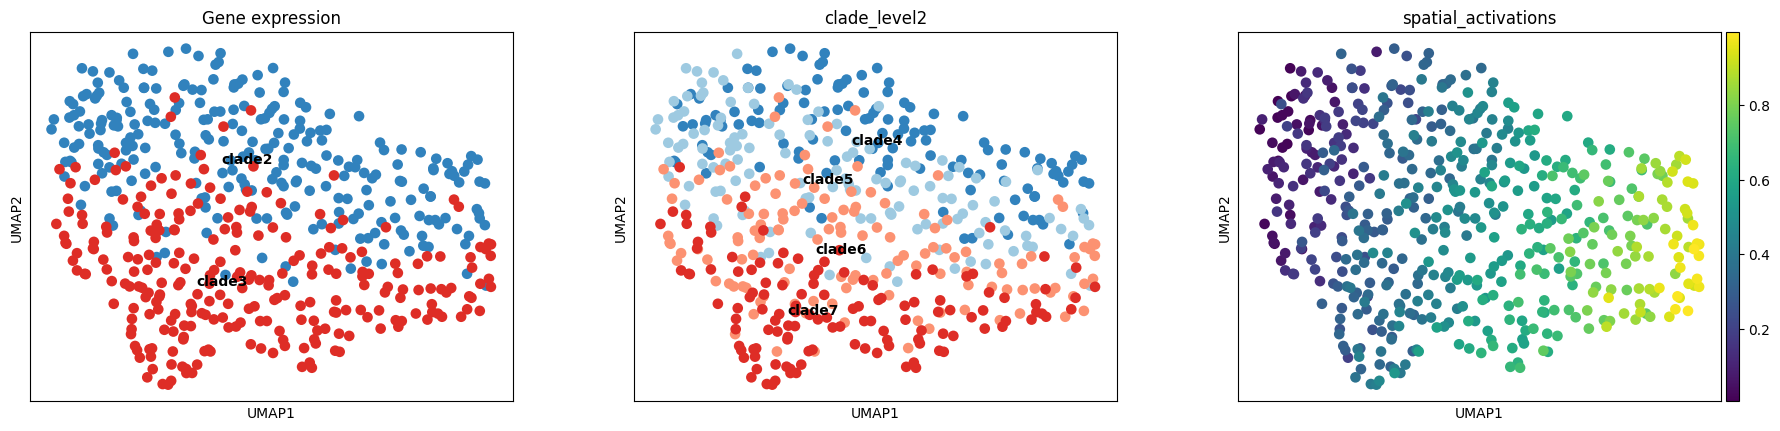

/home/pedro/miniconda3/envs/benchmark_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/pedro/miniconda3/envs/benchmark_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


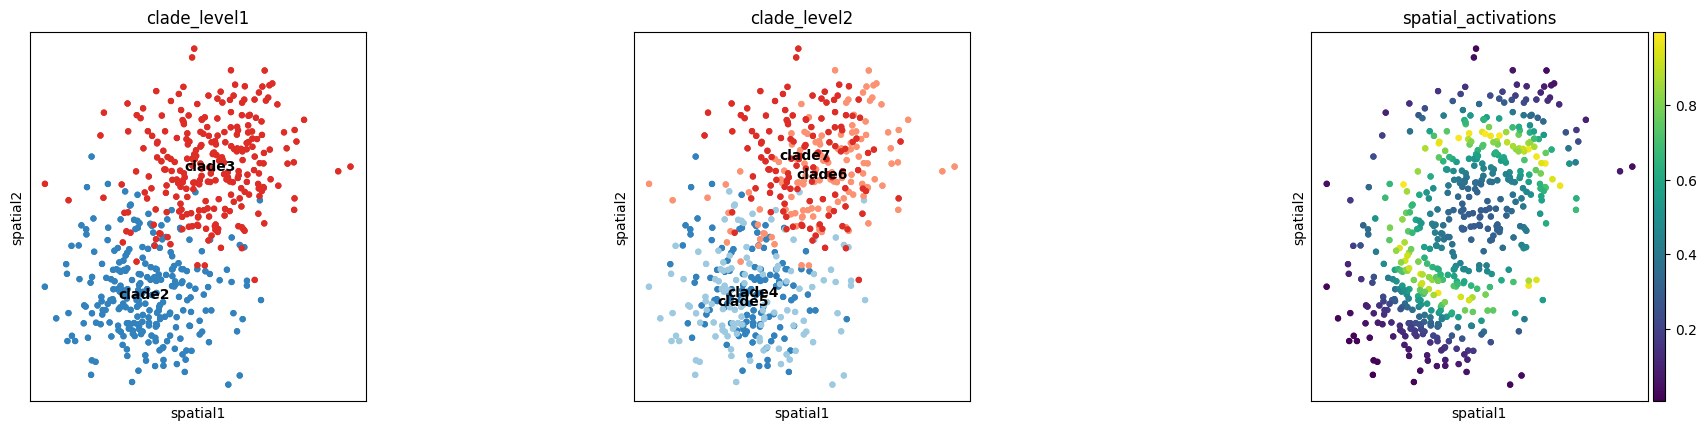

In [186]:
ss_simulated_adata.uns['clade_level1_colors'] = ['#3182bd', '#de2d26',]
ss_simulated_adata.uns['clade_level2_colors'] = ['#3182bd', '#9ecae1', '#fc9272', '#de2d26']
sc.pp.neighbors(ss_simulated_adata)
sc.tl.umap(ss_simulated_adata)
sc.pl.umap(ss_simulated_adata, color=['clade_level1', 'clade_level2', 'spatial_activations'] , title='Gene expression', legend_loc='on data')
sq.pl.spatial_scatter(ss_simulated_adata, color=['clade_level1', 'clade_level2', 'spatial_activations'], library_id='puck1',
                    size=50, shape=None, legend_loc='on data', ncols=3)

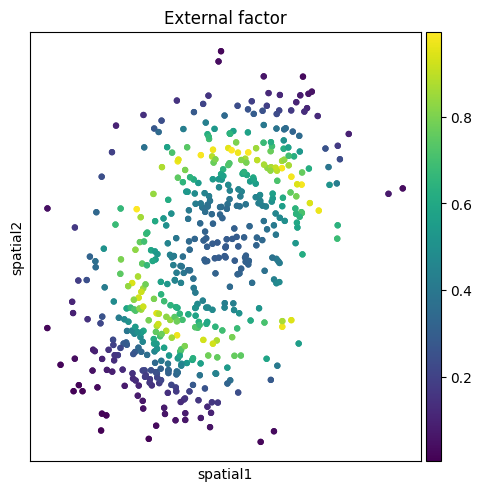

In [190]:
sq.pl.spatial_scatter(ss_simulated_adata, color=['spatial_activations'], title='External factor', library_id='puck1',
                    size=50, shape=None,  ncols=3)

/home/pedro/miniconda3/envs/benchmark_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


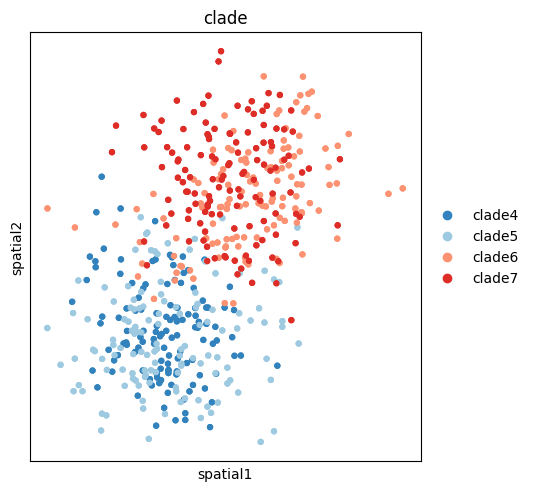

In [191]:
sq.pl.spatial_scatter(ss_simulated_adata, color=['clade_level2'], title='clade', library_id='puck1',
                    size=50, shape=None,  ncols=3)

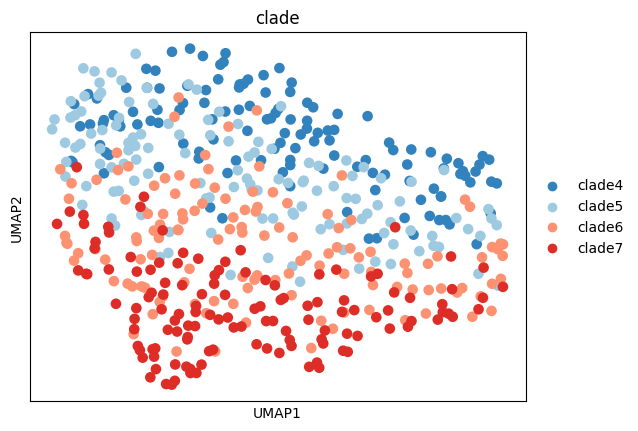

In [ ]:
sc.pl.umap(ss_simulated_adata, color=['clade_level2',] , title='clade')

In [ ]:
sc.pl.umap(ss_simulated_adata, color=['clade_level2',] , title='clade')

/tmp/ipykernel_1834119/3806327142.py:1: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  spatial_simulated_adata.uns['clade_level1_colors'] = ['#3182bd', '#de2d26',]
/home/pedro/.local/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 100 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


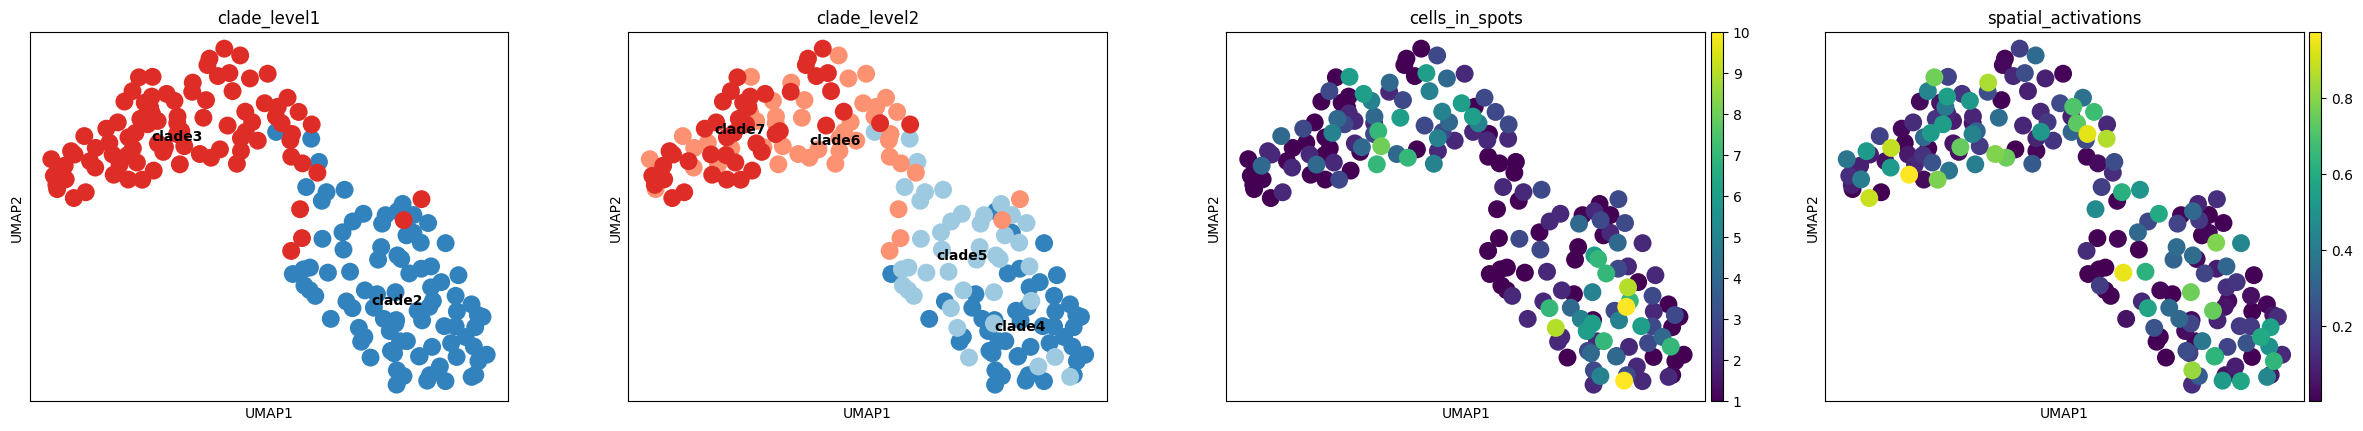

/home/pedro/miniconda3/envs/benchmark_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/pedro/miniconda3/envs/benchmark_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


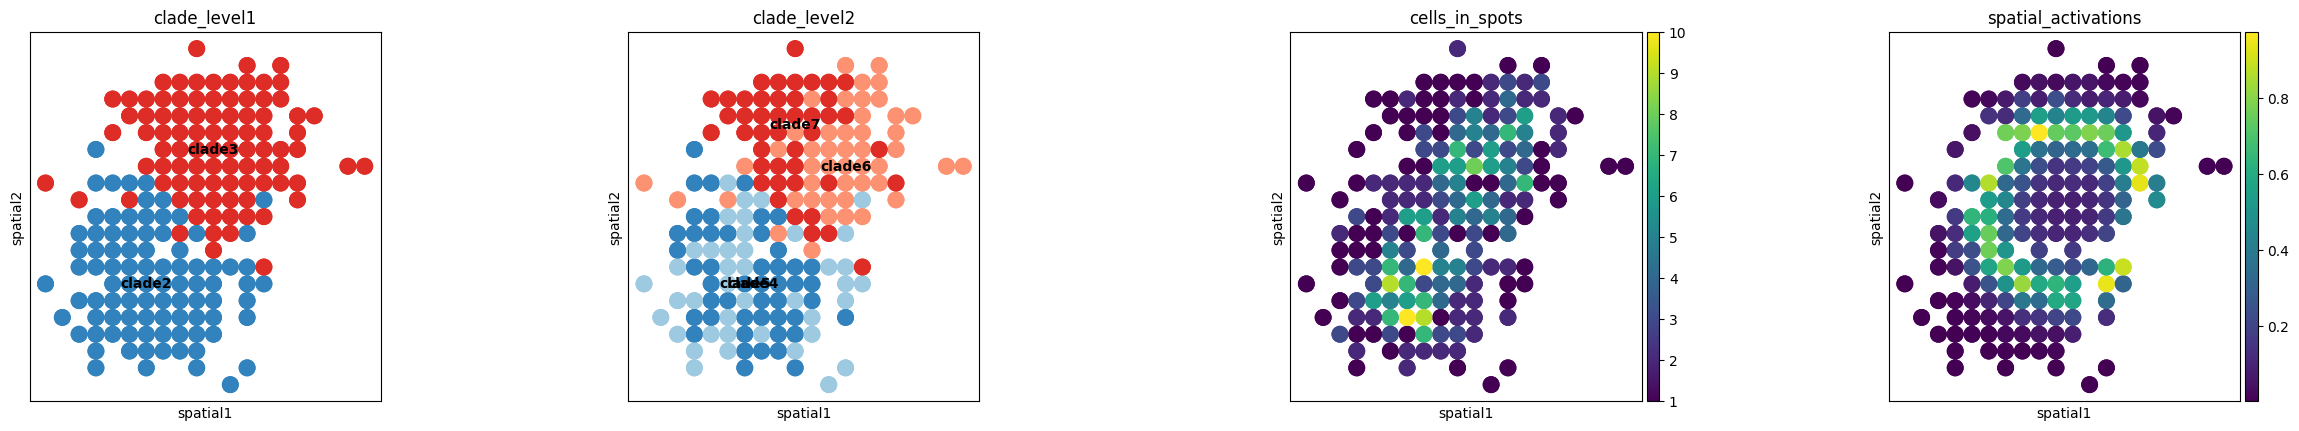

In [156]:
spatial_simulated_adata.uns['clade_level1_colors'] = ['#3182bd', '#de2d26',]
spatial_simulated_adata.uns['clade_level2_colors'] = ['#3182bd', '#9ecae1', '#fc9272', '#de2d26']
sc.pp.neighbors(spatial_simulated_adata)
sc.tl.umap(spatial_simulated_adata)
sc.pl.umap(spatial_simulated_adata, color=['clade_level1', 'clade_level2', 'cells_in_spots', 'spatial_activations'], legend_loc='on data')
sq.pl.spatial_scatter(spatial_simulated_adata, color=['clade_level1', 'clade_level2', 'cells_in_spots', 'spatial_activations'], 
                    library_id='puck1', shape=None, legend_loc='on data', size=500)

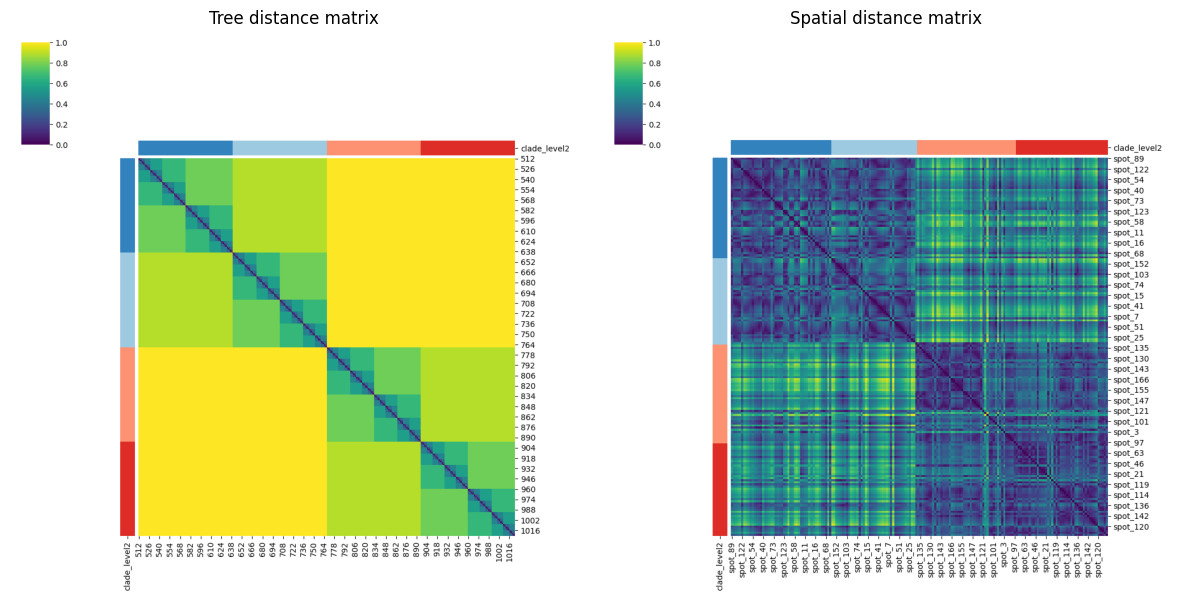

In [31]:
lut = dict(zip(["clade4", "clade5", "clade6", "clade7"], ss_simulated_adata.uns['clade_level2_colors']))
row_colors = ss_simulated_adata.obs['clade_level2'].map(lut)
g1 = sns.clustermap(tree_distance_matrix, row_cluster=False, col_cluster=False, row_colors=row_colors, col_colors=row_colors, cmap='viridis')

row_colors = spatial_simulated_adata.obs['clade_level2'].map(lut)
g2 = sns.clustermap(spatial_distance_matrix, row_cluster=False, col_cluster=False, row_colors=row_colors, col_colors=row_colors, cmap='viridis')

g1.figure.canvas.draw()
g2.figure.canvas.draw()

img1 = np.array(g1.figure.canvas.renderer.buffer_rgba())
img2 = np.array(g2.figure.canvas.renderer.buffer_rgba())

plt.close(g1.figure)
plt.close(g2.figure)

# Combine into one figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].set_title('Tree distance matrix')
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('Spatial distance matrix')
axes[1].axis('off')

plt.tight_layout()
plt.show()


/home/pedro/projects/spotr/phylospatial_mapping/notebooks/../src/spotr/utils.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'clade4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[subtree, 'clade'] = f'clade{node}'
/home/pedro/miniconda3/envs/benchmark_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


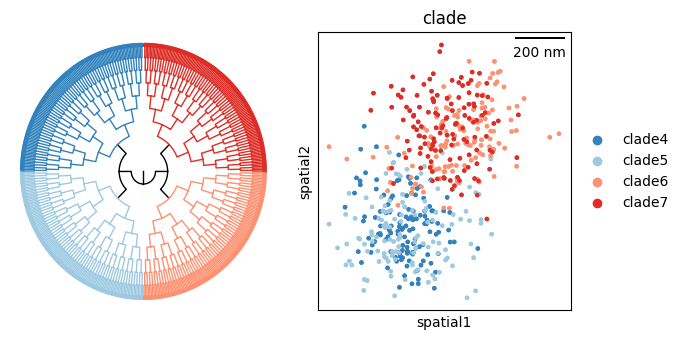

In [32]:
utils.plot_selection(simulated_tree, ss_simulated_adata, ['4', '5', '6', '7'], ['#3182bd', '#9ecae1', '#fc9272', '#de2d26'], orient=90)

In [99]:
res, spotr_out = run_methods(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix, true_couplings)

Wasserstein OT
GW OT
SpOTr


100%|██████████| 1000/1000 [00:16<00:00, 62.36it/s, loss=3.58e+6]


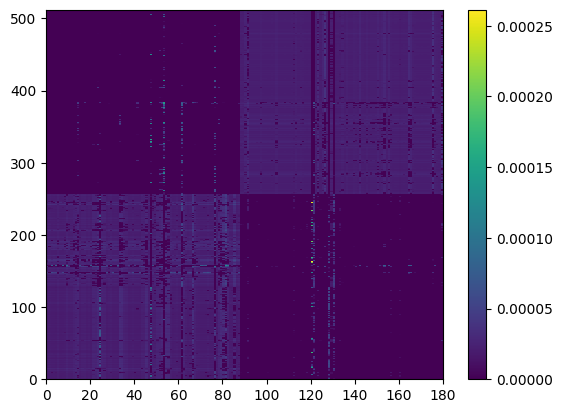

In [106]:
plt.pcolormesh(spotr_out['coupling'])
plt.colorbar()
plt.show()

In [103]:
spotr_out['alpha'], spotr_out['alpha_cross'], spotr_out['alpha_clades']

(Array([0.37727585], dtype=float32),
 Array([0.996684], dtype=float32),
 {'clade2': Array(0.8333728, dtype=float32),
  'clade3': Array(0.00331365, dtype=float32)})

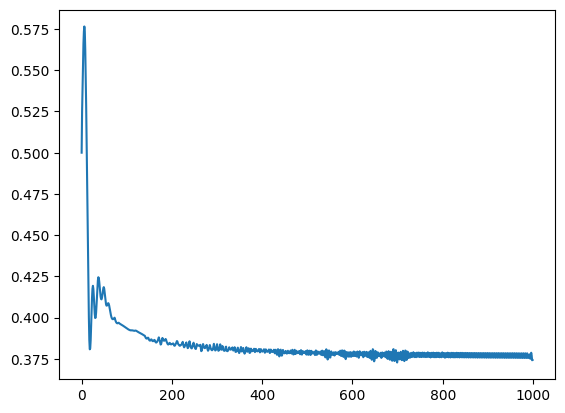

In [104]:
plt.plot(spotr_out['alpha_hist'][0])

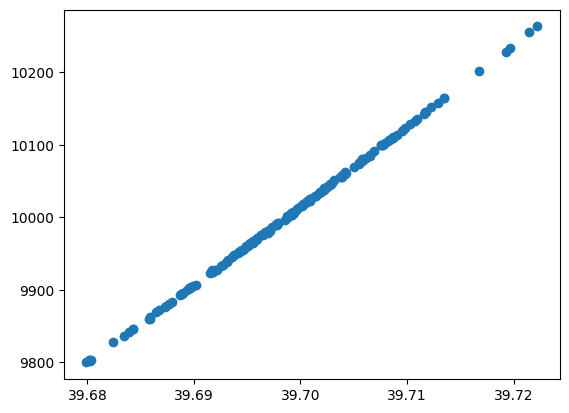

In [102]:
plt.scatter(spotr_out['spot_scales'].ravel(), np.sum(spatial_simulated_adata.layers['counts'], axis=1))

In [35]:
ss_simulated_adata.layers['counts'] = ss_simulated_adata.X.copy()
spatial_simulated_adata.layers['counts'] = spatial_simulated_adata.X.copy()
C_feature, C_tree, C_space, a, b = spotr.prepare_ot_inputs(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix.values, spatial_distance_matrix.values)
true_structure_score_level0 = utils.structural_concordance(C_tree, C_space, true_couplings)
level1_scores = []
for clade in ss_simulated_adata.obs['clade_level1'].unique():
    clade_idx = np.where(ss_simulated_adata.obs['clade_level1'] == clade)[0]
    true_structure_score_level1 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, true_couplings[clade_idx], eps=1e-12)
    level1_scores.append(true_structure_score_level1)
level2_scores = []
for clade in ss_simulated_adata.obs['clade_level2'].unique():
    clade_idx = np.where(ss_simulated_adata.obs['clade_level2'] == clade)[0]
    true_structure_score_level2 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, true_couplings[clade_idx], eps=1e-12)
    level2_scores.append(true_structure_score_level2)

In [66]:
print("Wasserstein OT")
# Run Wasserstein OT
coupling, _ = spotr.sinkhorn_fgw(C_feature, C_tree, C_space, a, b, 0.01, T_sinkhorn=100, J_alt=1, 
                            alpha=1.0, gamma0=coupling, uv0=None)
utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
structure_score_level0 = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)
level0_rmse = utils.compute_rmse(structure_score_level0, true_structure_score_level0)
level1_rmse = []
for i, clade in enumerate(ss_simulated_adata.obs['clade_level1'].unique()):
    clade_idx = np.where(ss_simulated_adata.obs['clade_level1'] == clade)[0]
    structure_score_level1 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
    level1_rmse.append(utils.compute_rmse(structure_score_level1, level1_scores[i]))
level1_rmse = np.mean(level1_rmse)
level2_rmse = []
for i, clade in enumerate(ss_simulated_adata.obs['clade_level2'].unique()):
    clade_idx = np.where(ss_simulated_adata.obs['clade_level2'] == clade)[0]
    structure_score_level2 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
    level2_rmse.append(utils.compute_rmse(structure_score_level2, level2_scores[i]))
level2_rmse = np.mean(level2_rmse)
print(mean_pearson_corr)

Wasserstein OT
0.517894052798817


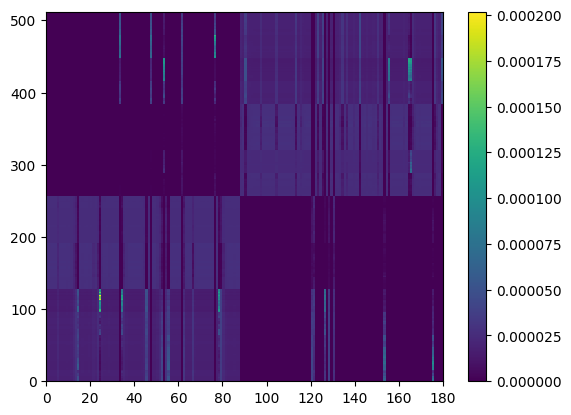

In [105]:
plt.pcolormesh(coupling)
plt.colorbar()
plt.show()

## Benchmarking routine

In [3]:
import importlib
import os

file_path = os.path.join(os.getcwd(), "../benchmark/DestVI/", "destvi.py")
spec = importlib.util.spec_from_file_location("destvi", file_path)
destvi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(destvi)

file_path = os.path.join(os.getcwd(), "../benchmark/scDOT/", "scdot.py")
spec = importlib.util.spec_from_file_location("scdot", file_path)
scdot = importlib.util.module_from_spec(spec)
spec.loader.exec_module(scdot)

In [1]:
n_reps = 1
n_cells = 256
n_genes = 10
n_traits = 5

spatial_mode = 'main_clades'
expression_mode = 'tree'
rep = 0

ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix, true_couplings, simulated_tree = utils.simulate_data(spatial_mode, expression_mode, seed=rep, n_cells=n_cells, n_genes=n_genes, n_traits=n_traits, obs_model='poisson')

NameError: name 'utils' is not defined

In [31]:
ss_simulated_adata.layers["counts"] = ss_simulated_adata.X.copy()

In [32]:
sc_model = destvi.fit_scLVM(ss_simulated_adata)

spatial_simulated_adata.layers["counts"] = spatial_simulated_adata.X.copy()
st_model = destvi.fit_stLVM(spatial_simulated_adata, sc_model)

props = st_model.get_proportions()

/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be

Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
/tmp/ipykernel_1106662/2203491461.py:3: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  spatial_simulated_adata.layers["counts"] = spatial_simulated_adata.X.copy()
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python

Training:   0%|          | 0/2500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2500` reached.


In [33]:
# scDOT
spatial_simulated_adata.uns["markers"] = ss_simulated_adata.uns['trait_signatures'].values
ss_simulated_adata.obsm["cell_type"] = ss_simulated_adata.obsm['trait_activations'].values / np.sum(ss_simulated_adata.obsm['trait_activations'].values, axis=1, keepdims=True)
_, coupling = scdot.train_scdot(ss_simulated_adata, spatial_simulated_adata)

In [49]:
file_path = os.path.join(os.getcwd(), "../src/spotr/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

In [51]:
cell_type_assignments = ss_simulated_adata.obsm['trait_activations'].values / np.sum(ss_simulated_adata.obsm['trait_activations'].values, axis=1, keepdims=True)
cell_type_signatures = ss_simulated_adata.uns['trait_signatures'].values # should probably learn this...
res = spotr.run_spotr(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix,
                                                            cell_type_assignments, cell_type_signatures,
                                                            clade_column='clade_level1')
res

100%|██████████| 100/100 [00:19<00:00,  5.08it/s, loss=2.21e+4]


{'alpha': Array([0.32107702], dtype=float32),
 'alpha_hist': Array([[0.5       , 0.49750006, 0.49499694, 0.4924939 , 0.489996  ,
         0.48750117, 0.48501253, 0.48252597, 0.48003897, 0.47755146,
         0.47506368, 0.4725723 , 0.47007802, 0.46757907, 0.46506366,
         0.46252888, 0.45998386, 0.45743212, 0.45487761, 0.45232075,
         0.44975403, 0.44717205, 0.44456872, 0.4419411 , 0.43929073,
         0.43661106, 0.43390328, 0.43114468, 0.42850247, 0.42573434,
         0.42463353, 0.42355296, 0.42249015, 0.42144063, 0.42040035,
         0.4193655 , 0.41833252, 0.41729802, 0.41626075, 0.41521707,
         0.41416445, 0.41310045, 0.41202393, 0.4109358 , 0.40983397,
         0.40871656, 0.40758184, 0.40642822, 0.4052544 , 0.4040591 ,
         0.4028437 , 0.40160754, 0.40034935, 0.39906788, 0.3977617 ,
         0.39643195, 0.3950769 , 0.393697  , 0.39229283, 0.39086613,
         0.3894152 , 0.38793808, 0.38643646, 0.3849116 , 0.3833645 ,
         0.38179335, 0.38019714, 0.37858143

In [116]:
spatial_modes = ['main_clades', 'subclades', 'main_and_subclades', 'unstructured']
expression_modes = ['tree', 'mix']
n_reps = 1
n_cells = 256
n_genes = 10
n_traits = 5


methods = ['Wasserstein OT', 'GW OT', 'SpOTr', 'scDOT', 'DestVI']
clade_structure_scores = []
results_rows = []
for spatial_mode in spatial_modes:
    for expression_mode in expression_modes:
        for rep in range(n_reps):
            print(spatial_mode, expression_mode, rep)
            # Simulate data and store info, we may use it later for scoring other methods
            ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix, true_couplings, simulated_tree = utils.simulate_data(spatial_mode, expression_mode, seed=rep, 
                                                                                                                                                                n_cells=n_cells, n_genes=n_genes, n_traits=n_traits, obs_model='poisson')
            ss_simulated_adata.layers['counts'] = ss_simulated_adata.X.copy()
            spatial_simulated_adata.layers['counts'] = spatial_simulated_adata.X.copy()
            C_feature, C_tree, C_space, a, b = spotr.prepare_ot_inputs(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix.values, spatial_distance_matrix.values)
            true_structure_score_level0 = utils.structural_concordance(C_tree, C_space, true_couplings)
            level1_scores = []
            for clade in ss_simulated_adata.obs['clade_level1'].unique():
                clade_idx = np.where(ss_simulated_adata.obs['clade_level1'] == clade)[0]
                true_structure_score_level1 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, true_couplings[clade_idx], eps=1e-12)
                level1_scores.append(true_structure_score_level1)
            level2_scores = []
            for clade in ss_simulated_adata.obs['clade_level2'].unique():
                clade_idx = np.where(ss_simulated_adata.obs['clade_level2'] == clade)[0]
                true_structure_score_level2 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, true_couplings[clade_idx], eps=1e-12)
                level2_scores.append(true_structure_score_level2)
            clade_structure_scores.append({
                'spatial_mode': spatial_mode,
                'expression_mode': expression_mode,
                'rep': rep,
                'structure_level0': true_structure_score_level0,
                'structure_level1': level1_scores,
                'structure_level2': level2_scores
            })


            rows, spotr_out = run_methods(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix, true_couplings, methods=methods, spatial_mode=spatial_mode, expression_mode=expression_mode, rep=rep)
            results_rows.extend(rows)
    results_df = pd.DataFrame(results_rows)

main_clades tree 0


/tmp/ipykernel_1834119/2651283049.py:20: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  spatial_simulated_adata.layers['counts'] = spatial_simulated_adata.X.copy()


Wasserstein OT
GW OT
SpOTr


100%|██████████| 1000/1000 [00:10<00:00, 99.64it/s, loss=nan]  
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


scDOT
DestVI


/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_da

Training:   0%|          | 0/2500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2500` reached.


main_clades mix 0


/tmp/ipykernel_1834119/2651283049.py:20: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  spatial_simulated_adata.layers['counts'] = spatial_simulated_adata.X.copy()


Wasserstein OT
GW OT
SpOTr


100%|██████████| 1000/1000 [00:10<00:00, 98.75it/s, loss=5.49e+6]
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


scDOT
DestVI


/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_da

Training:   0%|          | 0/2500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2500` reached.


subclades tree 0


/tmp/ipykernel_1834119/2651283049.py:20: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  spatial_simulated_adata.layers['counts'] = spatial_simulated_adata.X.copy()


Wasserstein OT
GW OT
SpOTr


100%|██████████| 1000/1000 [00:10<00:00, 99.49it/s, loss=5.6e+6] 
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


scDOT
DestVI


/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_da

Training:   0%|          | 0/2500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2500` reached.


subclades mix 0


/tmp/ipykernel_1834119/2651283049.py:20: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  spatial_simulated_adata.layers['counts'] = spatial_simulated_adata.X.copy()


Wasserstein OT
GW OT
SpOTr


100%|██████████| 1000/1000 [00:10<00:00, 99.36it/s, loss=5.67e+6]
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


scDOT
DestVI


/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_da

Training:   0%|          | 0/2500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2500` reached.


main_and_subclades tree 0


/tmp/ipykernel_1834119/2651283049.py:20: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  spatial_simulated_adata.layers['counts'] = spatial_simulated_adata.X.copy()


Wasserstein OT
GW OT
SpOTr


100%|██████████| 1000/1000 [00:10<00:00, 99.93it/s, loss=5.62e+6]
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


scDOT
DestVI


/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_da

Training:   0%|          | 0/2500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2500` reached.


main_and_subclades mix 0


/tmp/ipykernel_1834119/2651283049.py:20: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  spatial_simulated_adata.layers['counts'] = spatial_simulated_adata.X.copy()


Wasserstein OT
GW OT
SpOTr


100%|██████████| 1000/1000 [00:09<00:00, 100.41it/s, loss=5.75e+6]
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


scDOT
DestVI


/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_da

Training:   0%|          | 0/2500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2500` reached.


unstructured tree 0


/tmp/ipykernel_1834119/2651283049.py:20: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  spatial_simulated_adata.layers['counts'] = spatial_simulated_adata.X.copy()


Wasserstein OT
GW OT
SpOTr


100%|██████████| 1000/1000 [00:10<00:00, 92.56it/s, loss=6.12e+6]
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


scDOT
DestVI


/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_da

Training:   0%|          | 0/2500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2500` reached.


unstructured mix 0


/tmp/ipykernel_1834119/2651283049.py:20: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  spatial_simulated_adata.layers['counts'] = spatial_simulated_adata.X.copy()


Wasserstein OT
GW OT
SpOTr


100%|██████████| 1000/1000 [00:10<00:00, 91.72it/s, loss=6.21e+6]
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


scDOT
DestVI


/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pedro/.local/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/pedro/.local/lib/python3.10/site-packages/ipyk ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pedro/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_da

Training:   0%|          | 0/2500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2500` reached.


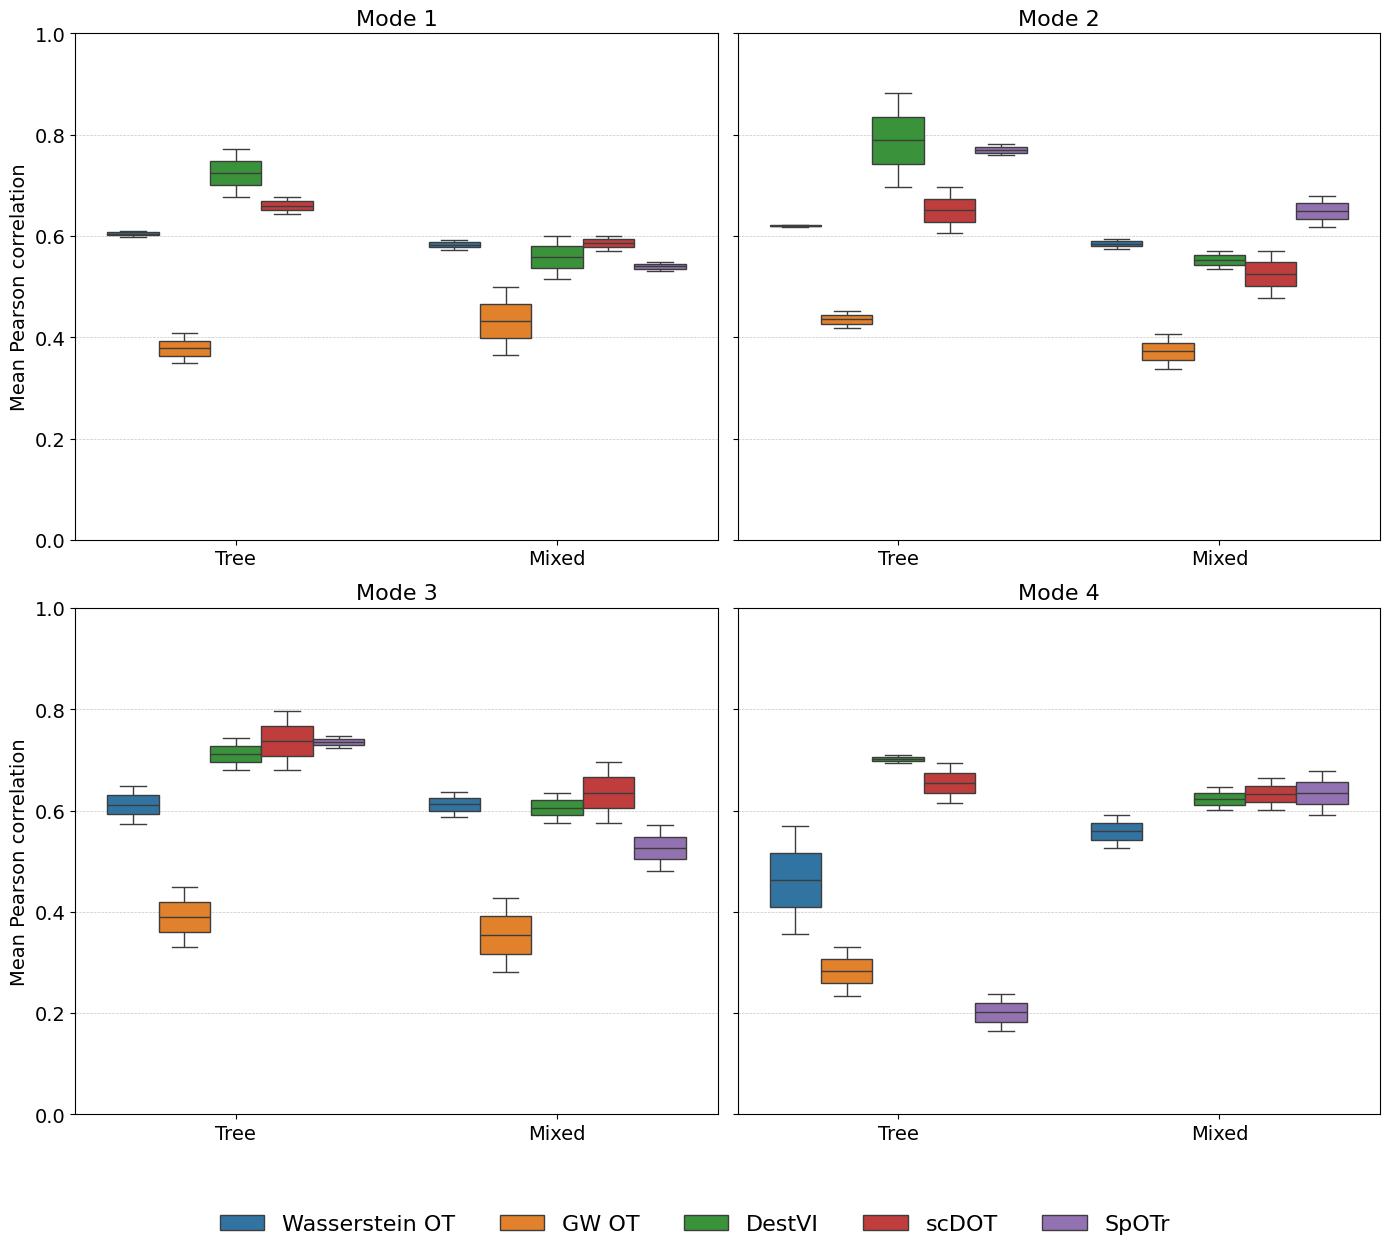

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns

methods_to_plot = ["Wasserstein OT", "GW OT", "DestVI", "scDOT", "SpOTr"]
filtered_df = both_results[both_results['method'].isin(methods_to_plot)]
filtered_df.replace('tree', 'Tree', inplace=True)
filtered_df.replace('mix', 'Mixed', inplace=True)

# Ensure the method column is categorical and sorted according to our desired order
filtered_df = filtered_df.copy()
filtered_df['method'] = pd.Categorical(filtered_df['method'], categories=methods_to_plot, ordered=True)

spatial_modes = filtered_df['spatial_mode'].unique()
expression_modes = filtered_df['expression_mode'].unique()
n_spatial_modes = len(spatial_modes)

fig, axes = plt.subplots(2, 2, figsize=(14, 12), sharey=True)
axes = axes.flatten()

# Keep a handle to the legend artists just once (for all plots)
legend_handles = None

for idx, spatial_mode in enumerate(spatial_modes):
    ax = axes[idx]
    data = filtered_df[filtered_df['spatial_mode'] == spatial_mode]
    if data.empty:
        continue
    sns_plot = sns.boxplot(
        data=data,
        x="expression_mode",
        y="pcorr",
        hue="method",
        hue_order=methods_to_plot,
        ax=ax
    )
    ax.set_title(f"Mode {idx+1}", fontsize=16)
    ax.set_xlabel("", fontsize=14)
    ax.set_ylabel("Mean Pearson correlation", fontsize=14)
    ax.set_ylim(0, 1)
    ax.grid(True, axis='y', which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)  # Increase ytick fontsize here
    # Capture legend handles/labels from the first non-empty plot, then remove legend from all axes
    if legend_handles is None:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
    ax.legend_.remove()

# Remove unused subplots if there are less than 4 spatial_modes
for j in range(len(spatial_modes), 4):
    fig.delaxes(axes[j])

# Create a new legend with all methods in a single horizontal row, placed below the figure
fig.legend(
    legend_handles, legend_labels, 
    loc='lower center', bbox_to_anchor=(0.5, -0.05),
    ncol=len(methods_to_plot), fontsize=16, frameon=False,
    title=""
)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()